In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('sbab033').getOrCreate()


In [2]:
df= spark.read.csv('cleaned_data.csv',header=True,inferSchema=True)

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [5]:
df.printSchema()

root
 |-- age: double (nullable = true)
 |-- creatinine_phosphokinase: double (nullable = true)
 |-- ejection_fraction: double (nullable = true)
 |-- platelets: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- serum_sodium: double (nullable = true)
 |-- time: double (nullable = true)
 |-- anaemia: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- high_blood_pressure: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)
 |-- smoking: integer (nullable = true)



In [6]:
df.columns

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'time',
 'anaemia',
 'diabetes',
 'high_blood_pressure',
 'sex',
 'DEATH_EVENT',
 'smoking']

In [7]:
# Combine all features into one vector named features.
assembler = VectorAssembler(
  inputCols=['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'time',
 'anaemia',
 'diabetes',
 'high_blood_pressure',
 'sex',
 'smoking'],outputCol="features")

In [8]:
df1 = assembler.transform(df)

In [9]:
df1.show(5)

+----+------------------------+-------------------+-------------------+--------------------+------------------+------------------+-------+--------+-------------------+---+-----------+-------+--------------------+
| age|creatinine_phosphokinase|  ejection_fraction|          platelets|    serum_creatinine|      serum_sodium|              time|anaemia|diabetes|high_blood_pressure|sex|DEATH_EVENT|smoking|            features|
+----+------------------------+-------------------+-------------------+--------------------+------------------+------------------+-------+--------+-------------------+---+-----------+-------+--------------------+
|40.0|     0.07279593697095976| 0.3181818181818181|0.23869559946660202|0.056179775280898875|0.5428571428571427|0.8540925266903915|      0|       1|                  0|  1|          0|      0|[40.0,0.072795936...|
|40.0|    0.013803880713634586| 0.3181818181818181| 0.2787004485392169|  0.0449438202247191|0.6857142857142855|0.7295373665480427|      1|       0| 

In [10]:
df1.printSchema()

root
 |-- age: double (nullable = true)
 |-- creatinine_phosphokinase: double (nullable = true)
 |-- ejection_fraction: double (nullable = true)
 |-- platelets: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- serum_sodium: double (nullable = true)
 |-- time: double (nullable = true)
 |-- anaemia: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- high_blood_pressure: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)
 |-- smoking: integer (nullable = true)
 |-- features: vector (nullable = true)



In [11]:
dtc = DecisionTreeClassifier(labelCol='DEATH_EVENT',featuresCol='features',seed = 1)

In [12]:
#pipeline = Pipeline(stages=[DEATH_EVENT, features, dtc])

In [13]:
final = df1.select("features", "DEATH_EVENT")

In [14]:
final.show(5)

+--------------------+-----------+
|            features|DEATH_EVENT|
+--------------------+-----------+
|[40.0,0.072795936...|          0|
|[40.0,0.013803880...|          0|
|[40.0,0.059252506...|          0|
|[40.0,0.008725094...|          0|
|[40.0,0.078265399...|          0|
+--------------------+-----------+
only showing top 5 rows



In [15]:
dtc_model = dtc.fit(final)

age Score: 0.00000
creatinine_phosphokinase Score: 0.07324
ejection_fraction Score: 0.13909
platelets Score: 0.01843
serum_creatinine Score: 0.08883
serum_sodium Score: 0.02305
time Score: 0.62726
anaemia Score: 0.03009
diabetes Score: 0.00000
high_blood_pressure Score: 0.00000
sex Score: 0.00000
smoking Score: 0.00000


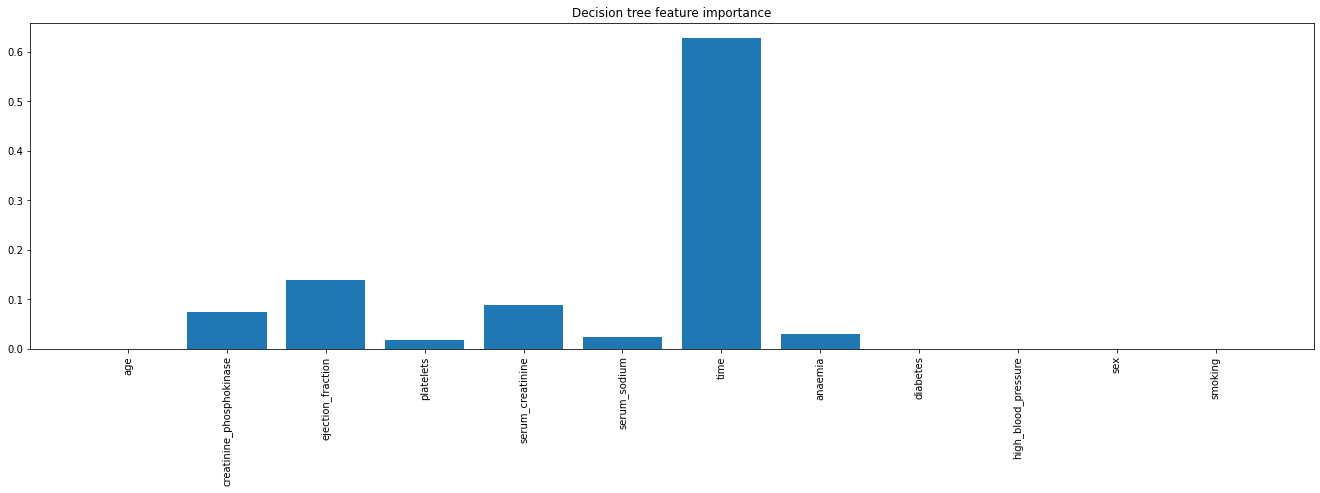

In [16]:
X = df.columns
X.remove("DEATH_EVENT") #label
importance = dtc_model.featureImportances
# summarize feature importance
i=0
for col in X:
    #print(col,importance[i])
    print(col,'Score: %.5f' % (importance[i]))
    i=i+1
import matplotlib.pyplot as plt
# summarize feature importance
plt.figure(figsize=(23,6))
plt.bar(X, dtc_model.featureImportances)
plt.xticks(rotation=90)
plt.title("Decision tree feature importance")
plt.show()

In [17]:
df=df.toPandas()

In [18]:
#only selection the important features
#df=df.toPandas()
df=df.drop(["diabetes","high_blood_pressure","sex","smoking"],axis=1)

In [19]:
df.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,DEATH_EVENT
0,40.0,0.072796,0.318182,0.238696,0.056180,0.542857,0.854093,0,0
1,40.0,0.013804,0.318182,0.278700,0.044944,0.685714,0.729537,1,0
2,40.0,0.059253,0.242424,0.336889,0.044944,0.657143,0.512456,0,0
3,40.0,0.008725,0.318182,0.278700,0.067416,0.657143,0.740214,0,0
4,40.0,0.078265,0.318182,0.334465,0.056180,0.828571,0.747331,0,0


In [20]:
y1 = df['DEATH_EVENT'] # output class
X1 = df.drop(['DEATH_EVENT'], axis=1)# input features
print(X1.shape, y1.shape)

(299, 8) (299,)


Counter({0: 203, 1: 96})


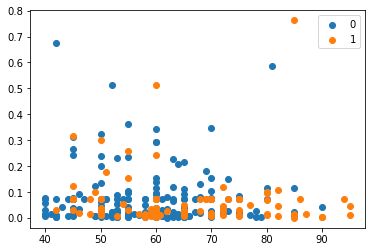

In [21]:
#imbalanced classification dataset
from collections import Counter
#from sklearn.datasets import make_classification
#from matplotlib import pyplot
from numpy import where
# summarize class distribution1
counter = Counter(y1)
y = y1.to_numpy()
X = X1.to_numpy()
print(counter)
# scatter plot of examples by class death_event
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [22]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
X1, y1 = oversample.fit_resample(X1, y1)

Counter({0: 203, 1: 203})


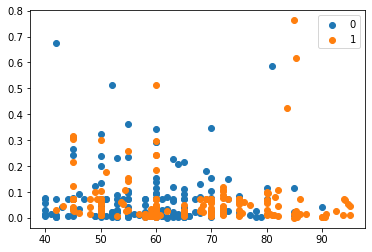

In [23]:
counter = Counter(y1)
y = y1.to_numpy()
X = X1.to_numpy()
print(counter)
# scatter plot of examples by class death_event
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [24]:
X1.shape

(406, 8)

In [25]:
y1.shape

(406,)

In [26]:
import pandas as pd

In [27]:
df= pd.concat([X1,y1],axis=1)
df.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,DEATH_EVENT
0,40.0,0.072796,0.318182,0.238696,0.056180,0.542857,0.854093,0,0
1,40.0,0.013804,0.318182,0.278700,0.044944,0.685714,0.729537,1,0
2,40.0,0.059253,0.242424,0.336889,0.044944,0.657143,0.512456,0,0
3,40.0,0.008725,0.318182,0.278700,0.067416,0.657143,0.740214,0,0
4,40.0,0.078265,0.318182,0.334465,0.056180,0.828571,0.747331,0,0


In [28]:
df.to_csv('balanced_data.csv', index=False)